In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir dos niveles desde tfm/templates/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [3]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2526'
MIN_MINUTES = 200

BARÇA_COLORS = {
    'primary': '#00FFFF',
    'secondary': '#DA0037'
}

LEVANTE_COLORS = {
    'primary': '#8B0000',
    'secondary': '#005ca5'
}

FW_PLAYERS = [
    {'name': 'Etta Eyong', 'search': 'Eyong', 'pos': 'FW', 'team': 'Levante', 'position_type': 'FW_CENTRO'},
    {'name': 'Robert Lewandowski', 'search': 'Lewandowski', 'pos': 'FW', 'team': 'Barcelona', 'position_type': 'FW_CENTRO'},
    {'name': 'Ferran Torres', 'search': 'Ferran Torres', 'pos': 'FW', 'team': 'Barcelona', 'position_type': 'FW_CENTRO'},
]

SAVE_PATH_BASE = "../images/etta_eyong/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [4]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2025-12-05 08:31:09,009 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-05 08:31:09,429 - database.connection - INFO - Database connection successful


Extraídos: 2281 registros, 10 columnas


unique_player_id         player_name     team              league season  \
0  4297cac0772af3c8           Ben White  Arsenal  ENG-Premier League   2526   
1  258ed61985702bb2         Bukayo Saka  Arsenal  ENG-Premier League   2526   
2  278433de9fa4c551  Christian Nørgaard  Arsenal  ENG-Premier League   2526   
3  e94c51c954d24b45  Cristhian Mosquera  Arsenal  ENG-Premier League   2526   
4  57f809b3be3768e0          David Raya  Arsenal  ENG-Premier League   2526   

  position nationality   age  \
0       DF         ENG  None   
1       FW         ENG  None   
2       MF         DEN  None   
3       DF         ESP  None   
4       GK         ESP  None   

                                       fbref_metrics  \
0  {'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '0',...   
1  {'FK': '2', 'OG': '0', 'Crs': '43', 'Fld': '23...   
2  {'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '0',...   
3  {'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '1',...   
4  {'CS': '7', 'FK': '0', 'OG': '0', '/90': '-0.1...   

                                   understat_metrics  
0  {'understat_xa': '0.585386723279953', 'underst...  
1  {'understat_xa': '3.2711187936365604', 'unders...  
2  {'understat_xa': '0.0', 'understat_team': 'Ars...  
3  {'understat_xa': '0.060570258647203445', 'unde...  
4  {'understat_xa': '0.049500007182359695', 'unde...

In [5]:
# Verificar posiciones disponibles
positions = df_raw['position'].value_counts().sort_index()
print(f"Posiciones: {sorted(df_raw['position'].unique())}")

# Filtrar por minutos mínimos
df_filtered = df_raw[
    df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min: {df_filtered.shape[0]} jugadores")
df_filtered.head()

Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Filtro 200+ min: 1688 jugadores


unique_player_id         player_name     team              league season  \
1  258ed61985702bb2         Bukayo Saka  Arsenal  ENG-Premier League   2526   
3  e94c51c954d24b45  Cristhian Mosquera  Arsenal  ENG-Premier League   2526   
4  57f809b3be3768e0          David Raya  Arsenal  ENG-Premier League   2526   
5  bb58d04ee12cd7fd         Declan Rice  Arsenal  ENG-Premier League   2526   
6  22123e3be762495a        Eberechi Eze  Arsenal  ENG-Premier League   2526   

  position nationality   age  \
1       FW         ENG  None   
3       DF         ESP  None   
4       GK         ESP  None   
5       MF         ENG  None   
6    MF,FW         ENG  None   

                                       fbref_metrics  \
1  {'FK': '2', 'OG': '0', 'Crs': '43', 'Fld': '23...   
3  {'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '1',...   
4  {'CS': '7', 'FK': '0', 'OG': '0', '/90': '-0.1...   
5  {'FK': '3', 'OG': '0', 'Crs': '65', 'Fld': '0'...   
6  {'FK': '0', 'OG': '0', 'Crs': '5', 'Fld': '12'...   

                                   understat_metrics  
1  {'understat_xa': '3.2711187936365604', 'unders...  
3  {'understat_xa': '0.060570258647203445', 'unde...  
4  {'understat_xa': '0.049500007182359695', 'unde...  
5  {'understat_xa': '2.722630264237523', 'underst...  
6  {'understat_xa': '1.9301875568926334', 'unders...

In [6]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [7]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [8]:
# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

Per90: 154 + 7


In [9]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 356
Percentiles totales: 356


In [10]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 1688 filas, 718 columnas
Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada: 716 columnas finales


In [11]:
# EXPLORACIÓN MÉTRICAS DISPONIBLES
print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_nums.columns))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

print("\nMÉTRICAS UNDERSTAT DISPONIBLES:")
print("=" * 50)
understat_sorted = sorted(list(understat_nums.columns))
for i, metric in enumerate(understat_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal Understat: {len(understat_sorted)}")

print("\nMÉTRICAS PER90 DISPONIBLES:")
print("=" * 50)
per90_sorted = sorted([col for col in all_metrics.columns if col.endswith('_per90')])
for i, metric in enumerate(per90_sorted[:20], 1):
    print(f"{i:2d}. {metric}")
if len(per90_sorted) > 20:
    print(f"... y {len(per90_sorted) - 20} más")

print(f"\nTotal Per90: {len(per90_sorted)}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [12]:
# Search FW centro players
player_ids = {}

print("FW CENTRO PLAYER SEARCH:")
print("=" * 50)

# Intentar múltiples patrones de búsqueda
search_patterns = {
    'Etta Eyong': ['Eyong', 'Etta Eyong', 'Etta'],
    'Robert Lewandowski': ['Lewandowski', 'Robert Lewandowski', 'Robert'],
    'Ferran Torres': ['Ferran Torres', 'Ferran Torres', 'Torres']
}

for player_name, patterns in search_patterns.items():
    found = False
    for pattern in patterns:
        if found:
            break
        search_results = df_filtered[
            df_filtered['player_name'].str.contains(pattern, case=False, na=False)
        ]
        
        if len(search_results) > 0:
            print(f"\n{player_name} - search: '{pattern}':")
            for _, p in search_results.iterrows():
                minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
                print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
                
                if player_name not in player_ids and p['position'].startswith('FW'):
                    player_ids[player_name] = p['unique_player_id']
                    print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                    found = True
                    break
    
    if not found:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

required_players = ['Etta Eyong', 'Robert Lewandowski', 'Ferran Torres']
missing_players = [name for name in required_players if name not in player_ids]

if missing_players:
    print(f"\nMISSING PLAYERS: {missing_players}")
else:
    print(f"\n✓ ALL PLAYERS FOUND")

FW CENTRO PLAYER SEARCH:

Etta Eyong - search: 'Eyong':
  14b378162f744173 - Karl Etta Eyong (Levante, ESP-La Liga, FW) - 793.0 min
  ✓ ASSIGNED: Etta Eyong -> 14b378162f744173

Robert Lewandowski - search: 'Lewandowski':
  c2a0808cd1a041ee - Robert Lewandowski (Barcelona, ESP-La Liga, FW) - 517.0 min
  ✓ ASSIGNED: Robert Lewandowski -> c2a0808cd1a041ee

Ferran Torres - search: 'Torres':
  7038310ad2ae51db - Pau Torres (Aston Villa, ENG-Premier League, DF) - 689.0 min
  234523677956f1cc - Ferrán Torres (Barcelona, ESP-La Liga, FW) - 785.0 min
  ✓ ASSIGNED: Ferran Torres -> 234523677956f1cc

PLAYERS FOUND:
  Etta Eyong: 14b378162f744173
  Robert Lewandowski: c2a0808cd1a041ee
  Ferran Torres: 234523677956f1cc

✓ ALL PLAYERS FOUND


In [13]:
'''
DELANTERO CENTRO (10 métricas) - LISTA DEFINITIVA:

1. expected_goals
2. goals
3. shots
4. Touches_Att Pen
5. expected_assists
6. Take-Ons_Succ
7. npxG/Sh
8. G-xG
9. Fld
10. shot creating actions

Analizando el radar de extremo que muestras y siguiendo la misma lógica, para **EXTREMO** seleccionaría estas 10 métricas:

EXTREMO (10 métricas) - LISTA DEFINITIVA:

1. expected_goals
2. shots  
3. expected_assists
4. Take-Ons_Succ
5. Touches_Att Pen
6. SCA_SCA90
7. Crs
8. Carries_PrgC
9. npxG/Sh
10. Fld

DEFENSA CENTRAL (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. Challenges_Tkl%
3. Aerial Duels_Won
4. Aerial Duels_Won%
5. Launched_Cmp
6. clearances
7. progressive_passes
8. Tkl+Int
9. interceptions
10. Blocks_Sh

LATERAL (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. progressive_passes
3. Carries_PrgC
4. Crs
5. passes_penalty_area
6. expected_assists
7. Touches_Att 3rd
8. Tkl+Int
9. Challenges_Tkl%
10. Take-Ons_Succ

MEDIOCENTRO (10 métricas) - LISTA DEFINITIVA EN ORDEN COHERENTE:

1. progressive_passes
2. Carries_PrgC
3. SCA_SCA90
4. expected_assists
5. passes_penalty_area
6. Take-Ons_Succ
7. Tkl+Int
8. interceptions
9. Fld
10. pass_completion_pct

PIVOTE (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. progressive_passes
3. Tkl+Int
4. interceptions
5. Challenges_Tkl%
6. Carries_PrgC
7. SCA_SCA90
8. Recov
9. Fld
10. expected_assists

PORTERO (10 métricas) - LISTA DEFINITIVA:

1. Save%
2. PSxG+/-
3. CS%
4. GA90
5. pass_completion_pct
6. Launched_Cmp%
7. Goal Kicks_Launch%
8. Sweeper_#OPA/90
9. Sweeper_AvgDist
10. SoT/90
'''

'\nDELANTERO CENTRO (10 métricas) - LISTA DEFINITIVA:\n\n1. expected_goals\n2. goals\n3. shots\n4. Touches_Att Pen\n5. expected_assists\n6. Take-Ons_Succ\n7. npxG/Sh\n8. G-xG\n9. Fld\n10. shot creating actions\n\nAnalizando el radar de extremo que muestras y siguiendo la misma lógica, para **EXTREMO** seleccionaría estas 10 métricas:\n\nEXTREMO (10 métricas) - LISTA DEFINITIVA:\n\n1. expected_goals\n2. shots  \n3. expected_assists\n4. Take-Ons_Succ\n5. Touches_Att Pen\n6. SCA_SCA90\n7. Crs\n8. Carries_PrgC\n9. npxG/Sh\n10. Fld\n\nDEFENSA CENTRAL (10 métricas) - LISTA DEFINITIVA:\n\n1. pass_completion_pct\n2. Challenges_Tkl%\n3. Aerial Duels_Won\n4. Aerial Duels_Won%\n5. Launched_Cmp\n6. clearances\n7. progressive_passes\n8. Tkl+Int\n9. interceptions\n10. Blocks_Sh\n\nLATERAL (10 métricas) - LISTA DEFINITIVA:\n\n1. pass_completion_pct\n2. progressive_passes\n3. Carries_PrgC\n4. Crs\n5. passes_penalty_area\n6. expected_assists\n7. Touches_Att 3rd\n8. Tkl+Int\n9. Challenges_Tkl%\n10. Take

In [14]:
# Position metrics configuration
gk_metrics = [
    'Save%', 'PSxG+/-', 'CS%', 'GA90', 'pass_completion_pct',
    'Launched_Cmp%', 'Goal Kicks_Launch%', 'Sweeper_#OPA/90', 'Sweeper_AvgDist', 'SoT/90'
]

gk_titles = [
    'Save %', 'PSxG +/-', 'Clean Sheets %', 'Goals Against', 'Pass Accuracy %',
    'Long Pass %', 'Long Kicks %', 'Sweeper Actions', 'Sweeper Distance', 'Shots Faced /90'
]

df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per90', 'Aerial Duels_Won%',
    'passes_final_third_per90', 'clearances_per90', 'progressive_passes_per90', 'Tkl+Int_per90',
    'interceptions_per90', 'Blocks_Sh_per90'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

lateral_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Carries_PrgC_per90', 'Crs_per90',
    'passes_penalty_area_per90', 'expected_assists_per90', 'Touches_Att 3rd_per90', 
    'Tkl+Int_per90', 'Challenges_Tkl%', 'Take-Ons_Succ_per90'
]
lateral_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Progressive Carries', 'Crosses',
    'Box Passes', 'Expected Assists', 'Touches Final Third', 
    'Tackles + Interceptions', 'Tackle Success %', 'Dribbles'
]

mf_metrics = [
    'progressive_passes_per90', 'Carries_PrgC_per90', 'SCA_SCA90', 'expected_assists_per90',
    'passes_penalty_area_per90', 'Take-Ons_Succ_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Fld_per90', 'pass_completion_pct'
]
mf_titles = [
    'Progressive Passes', 'Progressive Carries', 'Shot Creating Actions', 'Expected Assists',
    'Box Passes', 'Dribbles', 'Tackles + Interceptions', 'Interceptions',
    'Fouls Drawn', 'Pass Accuracy %'
]

pivote_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Challenges_Tkl%', 'Carries_PrgC_per90', 'SCA_SCA90', 'Recov_per90',
    'Fld_per90', 'expected_assists_per90'
]
pivote_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Tackles + Interceptions', 'Interceptions',
    'Tackle Success %', 'Progressive Carries', 'Shot Creating Actions', 'Recoveries',
    'Fouls Drawn', 'Expected Assists'
]

extremo_metrics = [
    'expected_goals_per90', 'shots_per90', 'expected_assists_per90', 'Take-Ons_Succ_per90',
    'Touches_Att Pen_per90', 'SCA_SCA90', 'Crs_per90', 'Carries_PrgC_per90',
    'npxG/Sh', 'Fld_per90'
]
extremo_titles = [
    'Expected Goals', 'Shots', 'Expected Assists', 'Dribbles',
    'Touches in Box', 'Shot Creating Actions', 'Crosses', 'Progressive Carries',
    'npxG per Shot', 'Fouls Drawn'
]

fw_metrics = [
    'expected_goals_per90', 'goals_per90', 'shots_per90', 'Touches_Att Pen_per90',
    'expected_assists_per90', 'Take-Ons_Succ_per90', 'npxG/Sh', 'G-xG_per90',
    'Fld_per90', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

configs = [
    ('GK', gk_metrics, gk_titles),
    ('DF Central', df_metrics, df_titles),
    ('DF Lateral', lateral_metrics, lateral_titles),
    ('MF', mf_metrics, mf_titles),
    ('MF Pivote', pivote_metrics, pivote_titles),
    ('FW Extremo', extremo_metrics, extremo_titles),
    ('FW Centro', fw_metrics, fw_titles)
]

print("POSITION METRICS VERIFICATION:")
print("=" * 50)
for pos, metrics, titles in configs:
    status = "OK" if len(metrics) == 10 and len(titles) == 10 else "ERROR"
    print(f"{status} {pos}: {len(metrics)} metrics, {len(titles)} titles")

print(f"\nTOTAL POSITIONS: {len(configs)}")

POSITION METRICS VERIFICATION:
OK GK: 10 metrics, 10 titles
OK DF Central: 10 metrics, 10 titles
OK DF Lateral: 10 metrics, 10 titles
OK MF: 10 metrics, 10 titles
OK MF Pivote: 10 metrics, 10 titles
OK FW Extremo: 10 metrics, 10 titles
OK FW Centro: 10 metrics, 10 titles

TOTAL POSITIONS: 7


In [15]:
# FW Centro comparisons configuration
FW_COMPARISONS = [
    {
        'name': 'Eyong_vs_Lewandowski',
        'player1': 'Etta Eyong',
        'player2': 'Robert Lewandowski', 
        'position_type': 'FW_CENTRO',
        'metrics_key': 'fw_centro',
        'title': 'Etta Eyong vs Robert Lewandowski (Delanteros Centro)',
        'faces': ['../caras/extras/Eyong.png', '../caras/extras/Lewandoski.png'],
        'colors': [LEVANTE_COLORS['primary'], BARÇA_COLORS['primary']]
    },
    {
        'name': 'Eyong_vs_Ferran', 
        'player1': 'Etta Eyong',
        'player2': 'Ferran Torres',
        'position_type': 'FW_CENTRO',
        'metrics_key': 'fw_centro',
        'title': 'Etta Eyong vs Ferran Torres (Delanteros Centro)',
        'faces': ['../caras/extras/Eyong.png', '../caras/españa/Ferran.png'],
        'colors': [LEVANTE_COLORS['primary'], BARÇA_COLORS['primary']]
    }
]

METRICS_BY_POSITION = {
    'fw_centro': {'metrics': fw_metrics, 'titles': fw_titles}
}

print(f"COMPARISONS: {len(FW_COMPARISONS)}")
for i, comp in enumerate(FW_COMPARISONS, 1):
    print(f"{i}. {comp['title']}")

print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISONS: 2
1. Etta Eyong vs Robert Lewandowski (Delanteros Centro)
2. Etta Eyong vs Ferran Torres (Delanteros Centro)

METRICS BY POSITION:
OK fw_centro: 10 metrics, 10 titles


FW CENTRO PLAYER RADAR GENERATION

Processing: Etta Eyong vs Robert Lewandowski (Delanteros Centro)
  Dataset: 395 players (FW)
  Team logos: Levante -> ../caras/extras/Eyong.png, Barcelona -> ../caras/extras/Lewandoski.png
  Colors: ['#8B0000', '#00FFFF']
  Completed: Eyong_vs_Lewandowski_combined.png
  Etta Eyong vs Robert Lewandowski


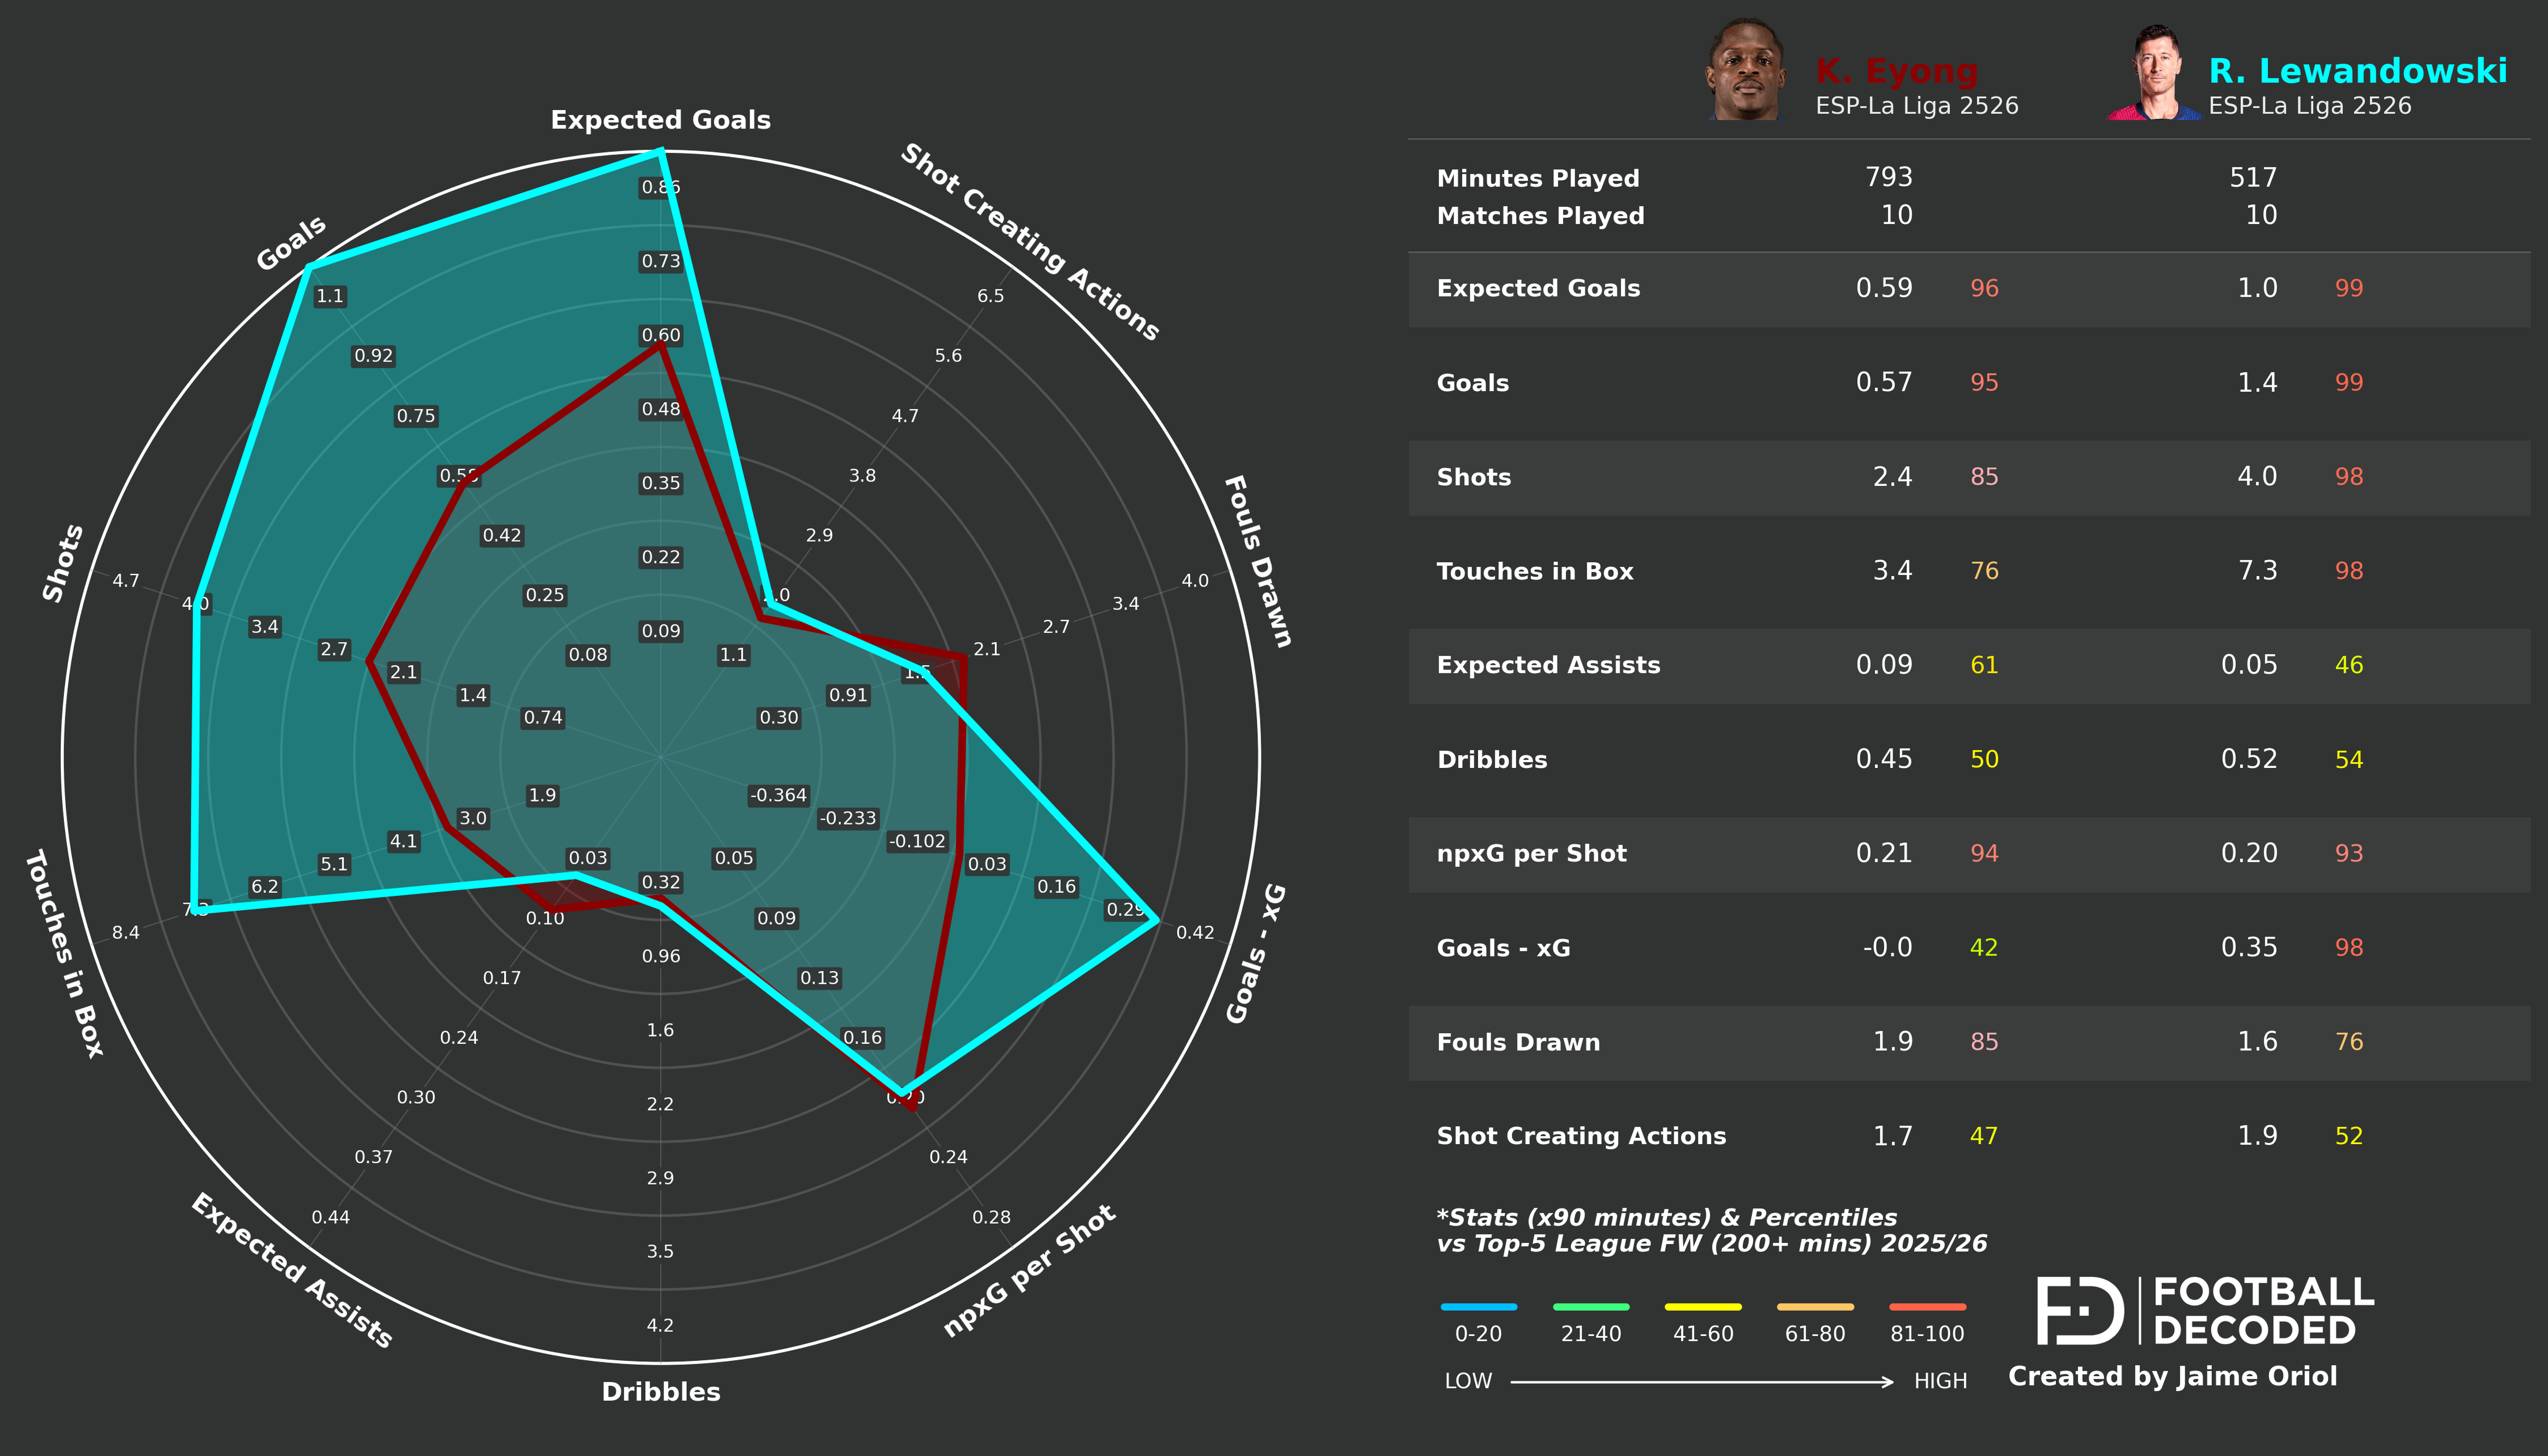


Processing: Etta Eyong vs Ferran Torres (Delanteros Centro)
  Dataset: 395 players (FW)
  Team logos: Levante -> ../caras/extras/Eyong.png, Barcelona -> ../caras/españa/Ferran.png
  Colors: ['#8B0000', '#00FFFF']
  Completed: Eyong_vs_Ferran_combined.png
  Etta Eyong vs Ferran Torres


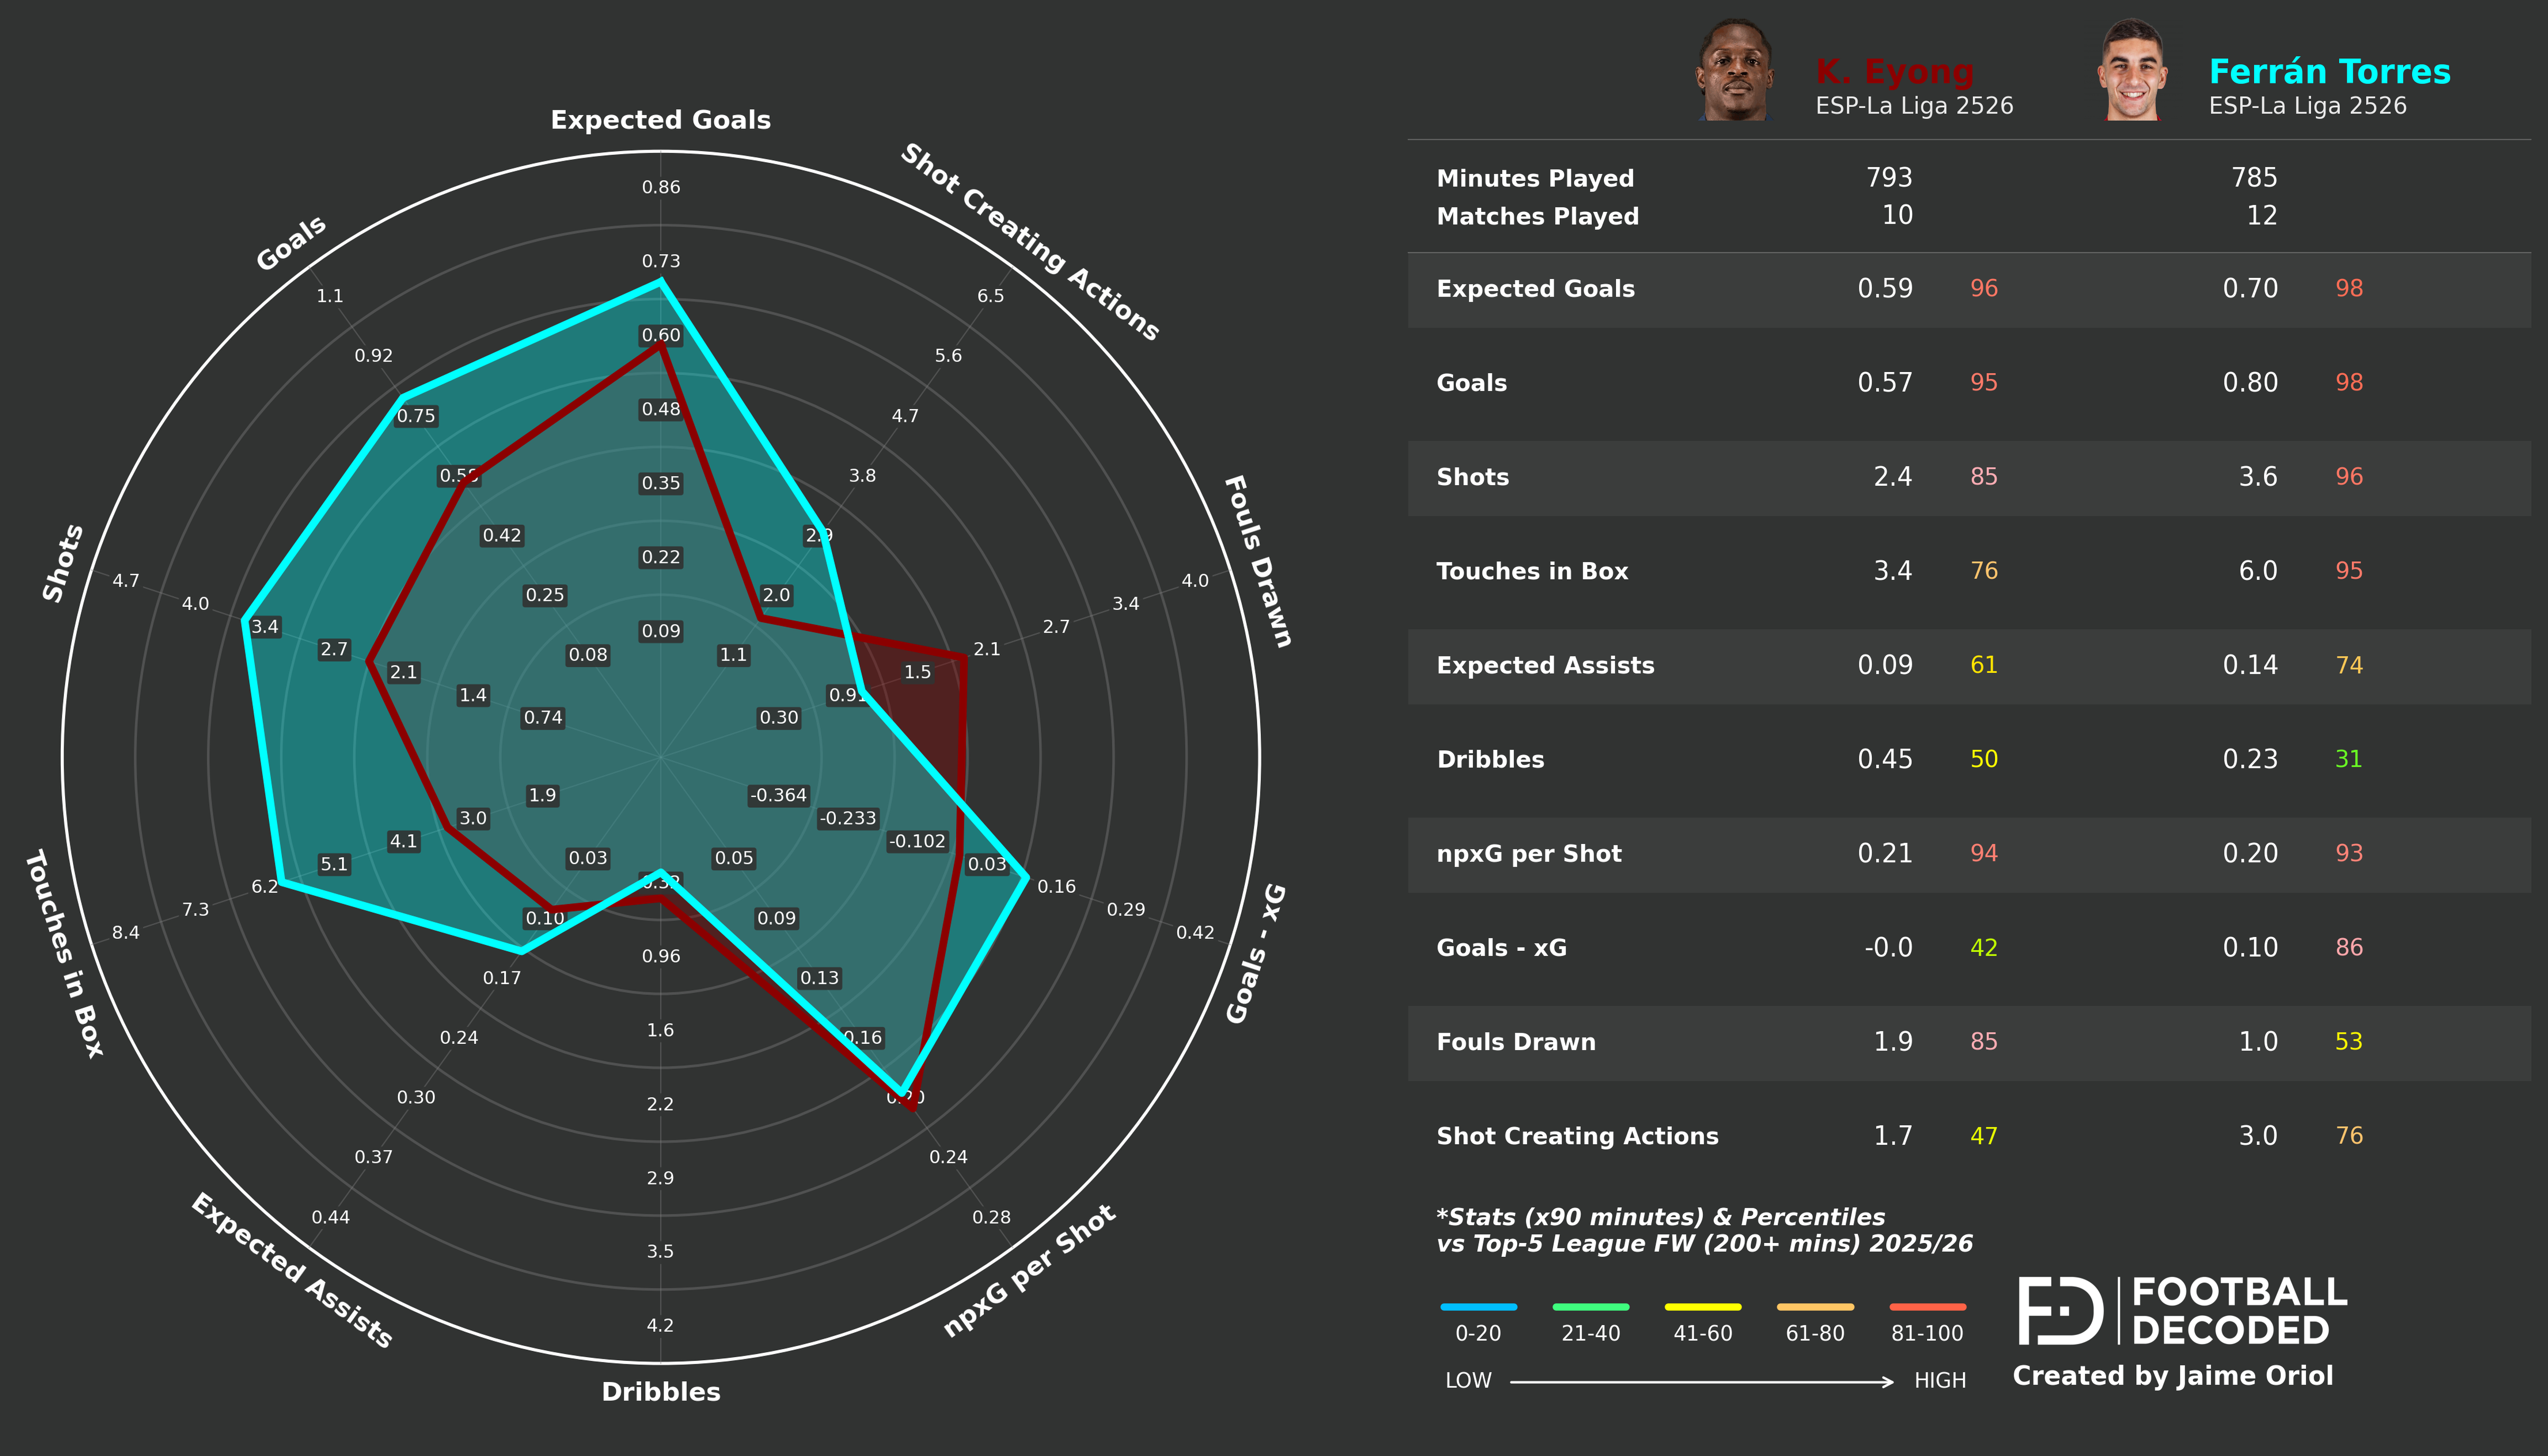


FW CENTRO COMPARISON RADAR SUMMARY
Successful comparisons: 2
Failed comparisons: 0
Files generated in: ../images/etta_eyong/

2 player comparison radars completed
Using team colors (Levante/Barcelona)
Player faces included in tables


In [16]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

# Generate FW centro player comparison radars
print("FW CENTRO PLAYER RADAR GENERATION")
print("=" * 50)

successful_comparisons = 0
failed_comparisons = 0

for comparison in FW_COMPARISONS:
    config_name = comparison['name']
    player1_name = comparison['player1'] 
    player2_name = comparison['player2']
    position_type = comparison['position_type']
    metrics_key = comparison['metrics_key']
    title = comparison['title']
    faces = comparison['faces']
    colors = comparison['colors']
    
    print(f"\nProcessing: {title}")
    
    if player1_name not in player_ids or player2_name not in player_ids:
        print(f"  Missing player ID")
        print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
        print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
        failed_comparisons += 1
        continue
    
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    if metrics_key not in METRICS_BY_POSITION:
        print(f"  Metrics not defined for {metrics_key}")
        failed_comparisons += 1
        continue
        
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Select dataset - FW centro are FW
    position_df = df_final[df_final['position'].str.startswith('FW')].copy()
    position_filter = "FW"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Get team names for the players
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {player1_team: faces[0], player2_team: faces[1]}
    
    print(f"  Team logos: {player1_team} -> {faces[0]}, {player2_team} -> {faces[1]}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (x90 minutes) & Percentiles\nvs Top-5 League {position_filter} (200+ mins) 2025/26",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  Completed: {config_name}_combined.png")
        print(f"  {player1_name} vs {player2_name}")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        successful_comparisons += 1
        
    except Exception as e:
        print(f"  Error: {str(e)}")
        failed_comparisons += 1

print("\n" + "=" * 50)
print("FW CENTRO COMPARISON RADAR SUMMARY")
print("=" * 50)
print(f"Successful comparisons: {successful_comparisons}")
print(f"Failed comparisons: {failed_comparisons}")
print(f"Files generated in: {SAVE_PATH_BASE}")

if successful_comparisons > 0:
    print(f"\n{successful_comparisons} player comparison radars completed")
    print("Using team colors (Levante/Barcelona)")
    print("Player faces included in tables")
else:
    print(f"\nNo radars generated. Check player IDs.")

ETTA EYONG INDIVIDUAL RADAR GENERATION

Processing: Etta Eyong Individual Radar
  Player ID: 14b378162f744173
  Dataset: 395 players (FW)
  Team: Levante
  Team logo: Levante -> ../caras/extras/Eyong.png
  Colors: ['#8B0000', '#005ca5']



✓ Completed: Eyong_individual_combined.png
  Individual radar for Etta Eyong


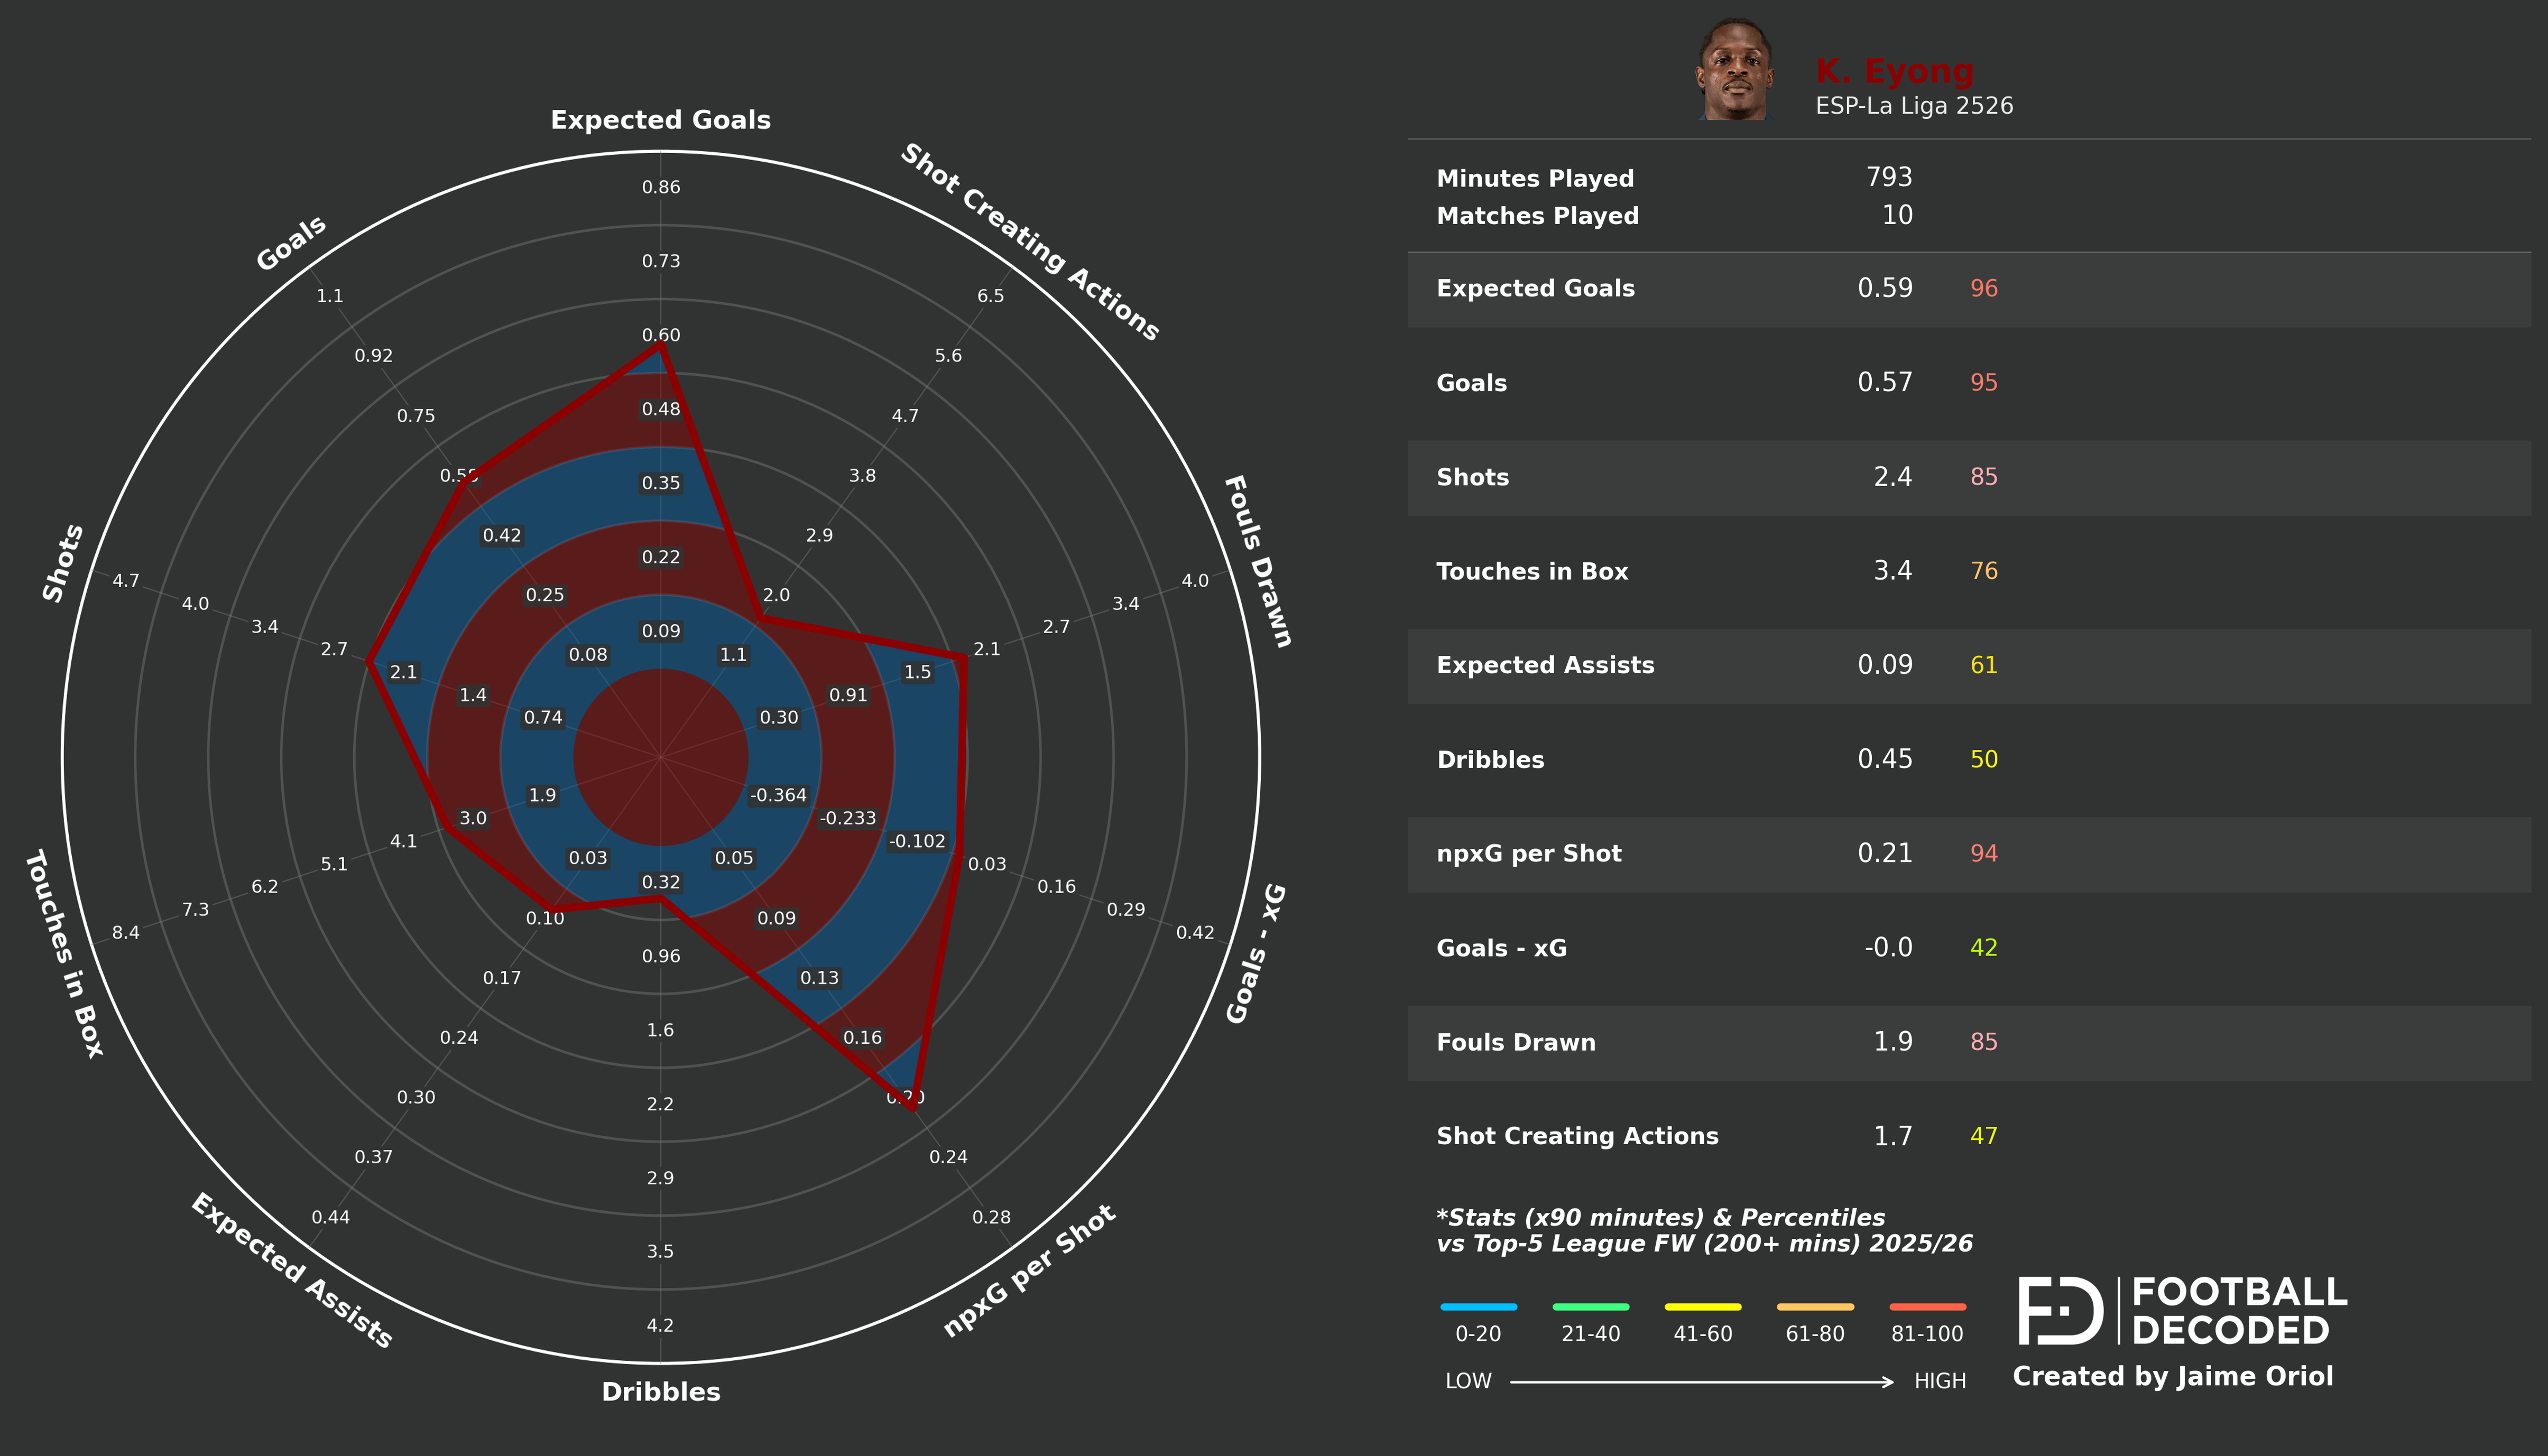


INDIVIDUAL RADAR SUMMARY
✓ Individual radar generated successfully
Files saved in: ../images/etta_eyong/
  - Eyong_individual_radar.png
  - Eyong_individual_table.png
  - Eyong_individual_combined.png


In [17]:
# Generate INDIVIDUAL radar for Etta Eyong
print("ETTA EYONG INDIVIDUAL RADAR GENERATION")
print("=" * 50)

player_name = 'Etta Eyong'
player_id = player_ids[player_name]

metrics_config = METRICS_BY_POSITION['fw_centro']
metrics = metrics_config['metrics']
metric_titles = metrics_config['titles']

# Select dataset - FW
position_df = df_final[df_final['position'].str.startswith('FW')].copy()
position_filter = "FW"

print(f"\nProcessing: {player_name} Individual Radar")
print(f"  Player ID: {player_id}")
print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")

# Get player team
player_team = df_final.loc[df_final['unique_player_id'] == player_id, 'team'].iloc[0]
print(f"  Team: {player_team}")

# Usar ambos colores del Levante para el radar individual
team_colors = [LEVANTE_COLORS['primary'], LEVANTE_COLORS['secondary']]
team_logos = {player_team: '../caras/extras/Eyong.png'}

print(f"  Team logo: {player_team} -> {team_logos[player_team]}")
print(f"  Colors: {team_colors}")

try:
    # Radar individual (sin player_2_id)
    create_player_radar(
        df_data=position_df,
        player_1_id=player_id,
        player_2_id=None,  # Sin comparación
        metrics=metrics,
        metric_titles=metric_titles,
        team_colors=team_colors,
        save_path=f"{SAVE_PATH_BASE}Eyong_individual_radar.png",
        use_swarm=False,
        show_plot=False
    )
    
    # Tabla individual
    create_stats_table(
        df_data=position_df,
        player_1_id=player_id,
        player_2_id=None,  # Sin comparación
        metrics=metrics,
        metric_titles=metric_titles,
        team_colors=team_colors,
        team_logos=team_logos,
        save_path=f"{SAVE_PATH_BASE}Eyong_individual_table.png",
        footer_text=f"Stats (x90 minutes) & Percentiles\nvs Top-5 League {position_filter} (200+ mins) 2025/26",
        show_plot=False
    )
    
    # Combinar radar y tabla
    combine_radar_and_table(
        radar_path=f"{SAVE_PATH_BASE}Eyong_individual_radar.png",
        table_path=f"{SAVE_PATH_BASE}Eyong_individual_table.png",
        output_path=f"{SAVE_PATH_BASE}Eyong_individual_combined.png"
    )
    
    print(f"\n✓ Completed: Eyong_individual_combined.png")
    print(f"  Individual radar for {player_name}")
    
    # Mostrar imagen
    display(IPImage(f"{SAVE_PATH_BASE}Eyong_individual_combined.png"))
    
    print("\n" + "=" * 50)
    print("INDIVIDUAL RADAR SUMMARY")
    print("=" * 50)
    print(f"✓ Individual radar generated successfully")
    print(f"Files saved in: {SAVE_PATH_BASE}")
    print("  - Eyong_individual_radar.png")
    print("  - Eyong_individual_table.png")
    print("  - Eyong_individual_combined.png")
    
except Exception as e:
    print(f"\n✗ Error generating individual radar: {str(e)}")
    import traceback
    traceback.print_exc()